<a href="https://colab.research.google.com/github/sbooeshaghi/intervals/blob/master/notebooks/elementary_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining elementary intervals

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq

from collections import defaultdict
from collections import OrderedDict
import random
import string

from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches

from collections import defaultdict

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_itvs(intervals, lengths, vals, title, ax):
  xmin = min(intervals, key=lambda x: x[0])[0]
  xmax = max(intervals, key=lambda x: x[1])[1]
  for idx, itv in enumerate(intervals, 0):
    mid = itv[0] + lengths[idx]/2
    y = [idx, idx]

    ax.plot(itv, y)
    l, r = itv
    y1, y2 = y
    ax.scatter(l, y1, color="k", zorder=10)
    ax.scatter(r, y2, facecolors="none", edgecolors="k", zorder=10)

    ax.annotate(vals[idx], (mid, idx+0.1), ha="center")

  # ax.axvline(x=q, color="black")
  ax.grid(axis='x')

  kwd = {
      "yticks": range(len(vals)),
      "yticklabels": vals,
      "xticks": range(xmin, xmax+1),
      "xticklabels":range(xmin, xmax+1)
  }
  ax.set(**kwd)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_title(title)

  return ax

# Generate intervals



In [3]:
def gen_itv(minimum, maximum, min_len, max_len):
  lower = random.randint(minimum, maximum)
  upper = random.randint(lower, maximum)
  while upper - lower < min_len or upper - lower > max_len:
    upper = random.randint(lower, maximum)

  return (lower, upper)

def gen_itvs(minimum, maximum, min_len, max_len, n):
  itvs = []
  for i in range(n):
    itvs.append(gen_itv(minimum, maximum, min_len, max_len))
  return itvs

In [178]:
n_itvs = 10 # must be less than 26 only because we use letters of the english alphabet to label each interval
max_pos = 30
min_pos = 0

min_len = 1
max_len = max_pos

intervals = gen_itvs(min_pos, max_pos, min_len, max_len, n_itvs)
lengths = [y-x for x, y in intervals]
values = [string.ascii_uppercase[i] for i in range(n_itvs)]

In [179]:
intervals

[(8, 20),
 (13, 26),
 (1, 30),
 (29, 30),
 (12, 18),
 (29, 30),
 (2, 4),
 (7, 25),
 (10, 18),
 (28, 29)]

# Generate BUS data distributed across n files from intervals

In [180]:
def distributed_sum(val, n):
  ret = []

  remain = val%n
  split = val//n
  ret = [split]*n

  for i in range(remain):
    ret[i] += 1

  return ret

In [181]:
# make bus data from intervals
n_files = 8
len_ints = len(intervals)

npf = distributed_sum(len_ints, n_files)

i = 0
total = 0
pq = []
nf = 0
for n in npf:
  total += n
  while i<total:
    x, y = intervals[i]
    v = values[i]

    heapq.heappush(pq, (v, (x, nf)))
    heapq.heappush(pq, (v, (y, nf)))

    i +=1 
  nf += 1
  

In [182]:
# The pq is now our bd
pq

[('A', (8, 0)),
 ('A', (20, 0)),
 ('B', (13, 0)),
 ('B', (26, 0)),
 ('C', (1, 1)),
 ('C', (30, 1)),
 ('D', (29, 1)),
 ('D', (30, 1)),
 ('E', (12, 2)),
 ('E', (18, 2)),
 ('F', (29, 3)),
 ('F', (30, 3)),
 ('G', (2, 4)),
 ('G', (4, 4)),
 ('H', (7, 5)),
 ('H', (25, 5)),
 ('I', (10, 6)),
 ('I', (18, 6)),
 ('J', (28, 7)),
 ('J', (29, 7))]

# Convert the BUS data back into intervals

In [183]:
bd = list(pq.copy())
itvs = []
vals = []
for i in range(0, len(bd), 2):
  itvs.append((bd[i][1][0], bd[i+1][1][0]))
  vals.append(bd[i][0])

In [184]:
itvs == intervals

True

In [185]:
values == vals

True

# Preprocess the intervals


In [186]:
unsorted = intervals.copy()

lidx = sorted(range(len(intervals)), key=lambda k: intervals[k][0])
ridx = sorted(range(len(intervals)), key=lambda k: intervals[k][1])

l = sorted(intervals, key=lambda itv: itv[0])
r = sorted(intervals, key=lambda itv: itv[1])

llengths = [lengths[i] for i in lidx]
rlengths = [lengths[i] for i in ridx]

lvals = [values[i] for i in lidx]
rvals = [values[i] for i in ridx]

# Generating all elementary intervals without regard to retaining information about contained intervals

In [187]:
elem = []
vals = []
lst = []
for v, el in zip(lvals, l):
  left, right = el[0], el[1]

  if left not in elem:
    elem.append(left)

  if right not in elem:
    elem.append(right)


elem.sort()
elem_itv = [(elem[i-1], elem[i]) for i in range(1,len(elem))]
elem_len = [y-x for x, y in elem_itv]

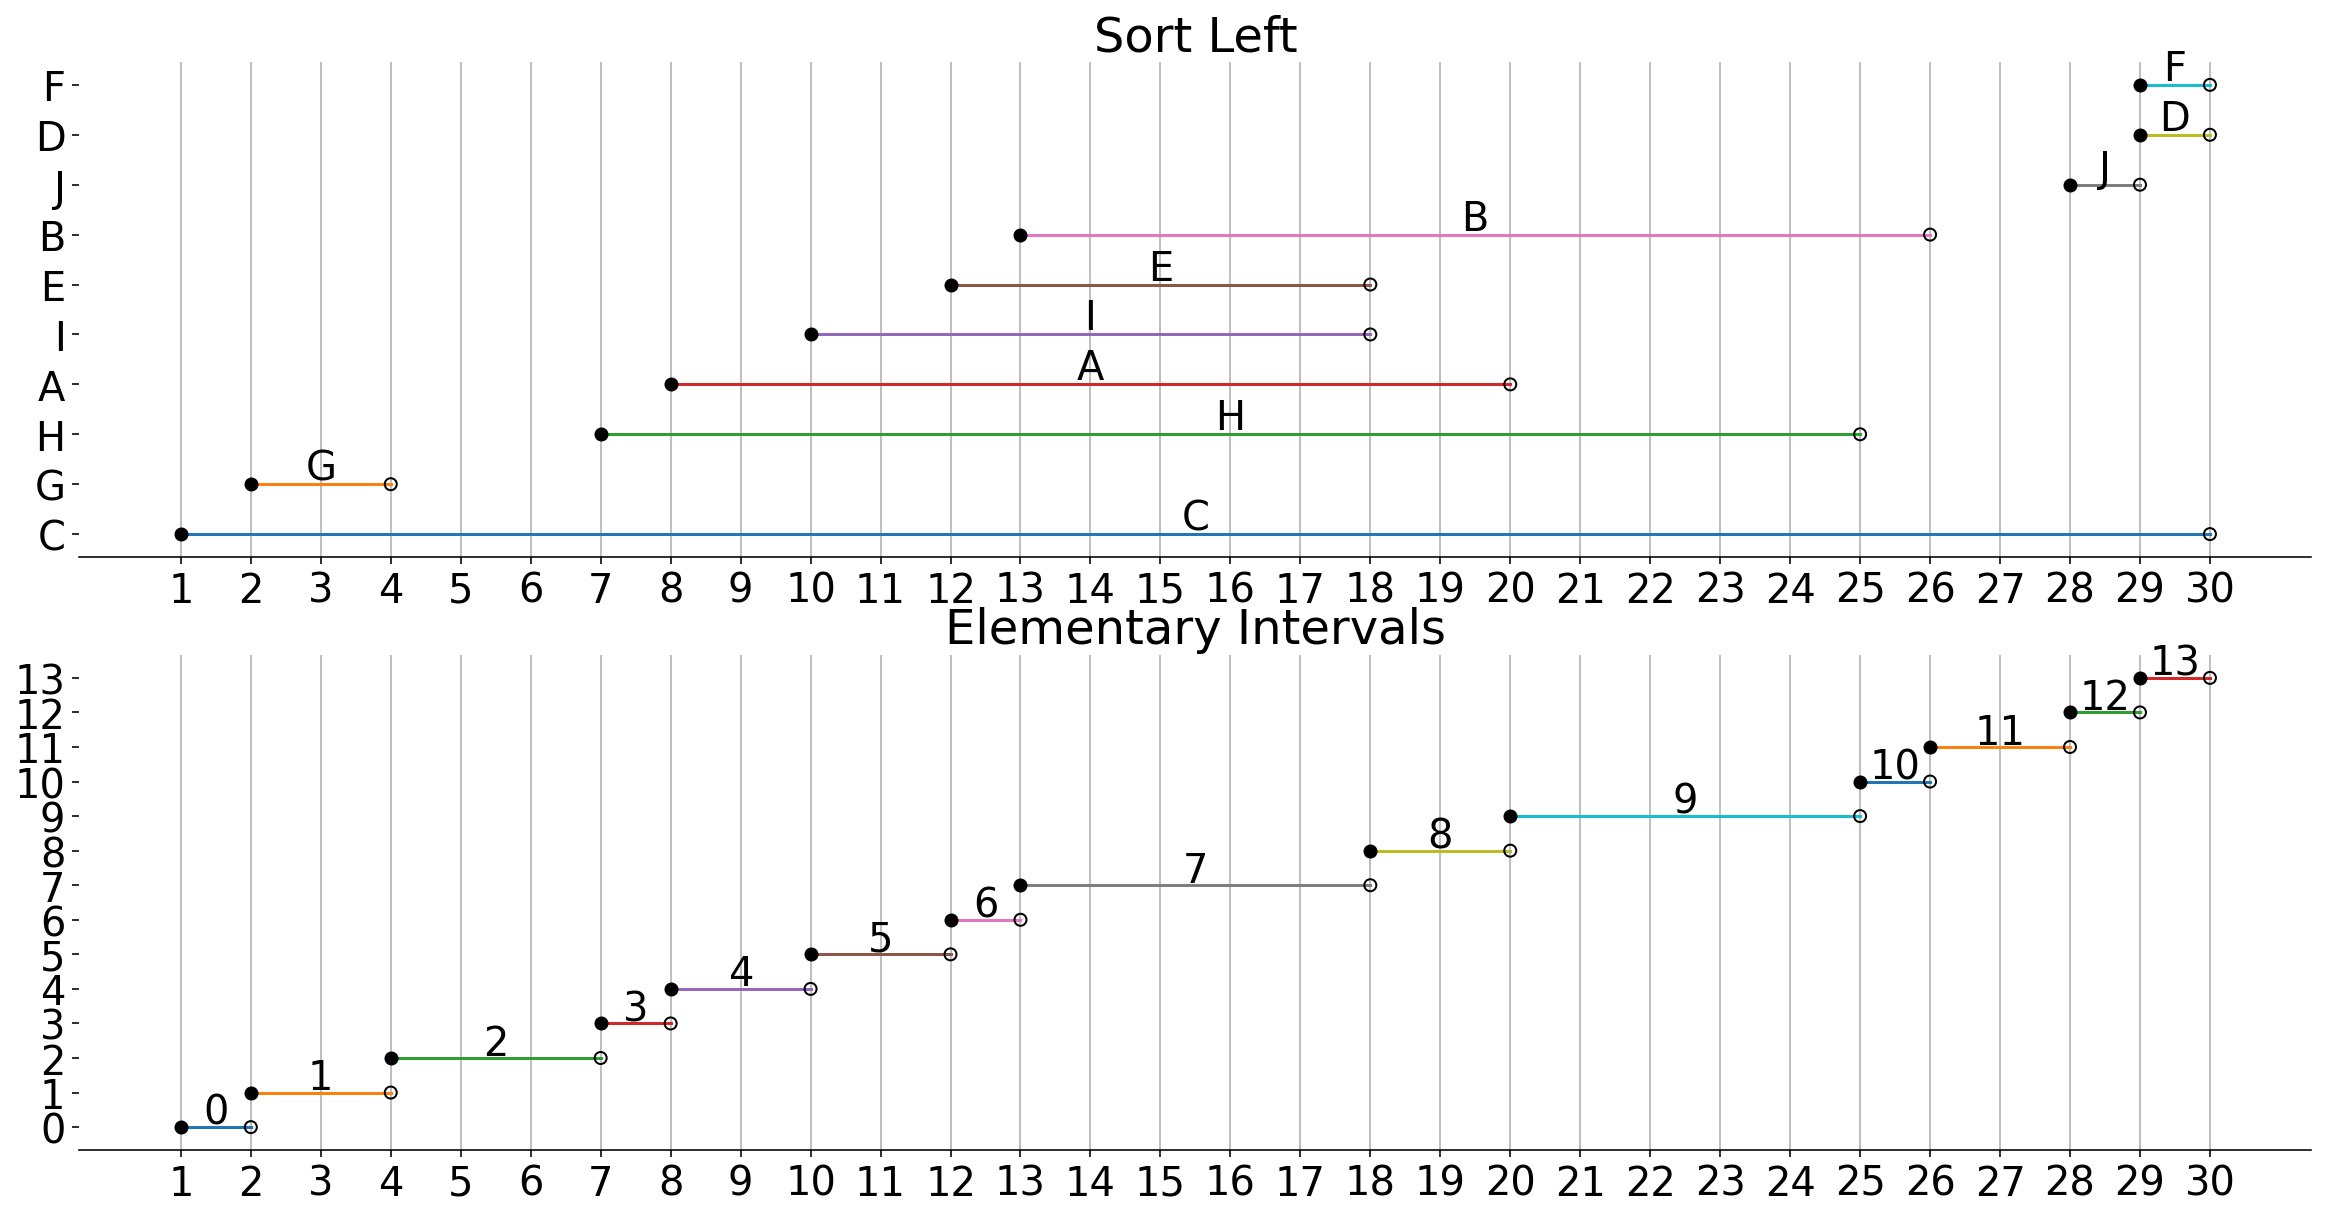

In [206]:
fig, ax = plt.subplots(figsize=(20,10), nrows=2)

plot_itvs(l, llengths, lvals, "Sort Left", ax[0])
plot_itvs(elem_itv, elem_len, range(len(elem_itv)), "Elementary Intervals", ax[1])

fig.show()

In [189]:
print(l)
print(r)

[(1, 30), (2, 4), (7, 25), (8, 20), (10, 18), (12, 18), (13, 26), (28, 29), (29, 30), (29, 30)]
[(2, 4), (12, 18), (10, 18), (8, 20), (7, 25), (13, 26), (28, 29), (1, 30), (29, 30), (29, 30)]


# Generate all elementary interals but retain information about which intervals are contained in that elementary interval

In [190]:
def get_elem_itvs(l, r, lvals, rvals):
  d = defaultdict(list)

  lidx = 0
  start = l[lidx][0] # left endpoint of first interval

  c = set()
  # for each right sorted endpoint
  for ridx in range(len(r)):
    # while still have intervals and left endpoint is less than right endpoint of new interval
    # ie L [a, b], R [c, d] => a < d
    c.add(rvals[ridx])
    while lidx < len(l) and l[lidx][0] <= r[ridx][1]:
      stop = l[lidx][0] # update stop to be left endpoint of L
      
      c.add(lvals[lidx])

      # if the left point of interval is greater than the start, its an elem interval
      if stop > start:
        c.add(rvals[ridx])
        d[(start, stop)] = c.copy()
        # update the start to be the stop of that interval
        start = stop
      
      lidx += 1
    # end of l intervals or. [a, b], [c, d] a >= d
    # if the prev interval and the current interval intersect at all
    if start < r[ridx][1]: 
      stop = r[ridx][1] # the stop is the end of that interval
      d[(start, stop)] = c.copy()
      start = stop 
    c.remove(rvals[ridx])

  return d

In [191]:
d = get_elem_itvs(l, r, lvals, rvals)

In [192]:
def plot_elem(itvs, lengths, vals, ax):
  # make some labels invisible
  

  xmin = min(itvs, key=lambda x: x[0])[0]
  xmax = max(itvs, key=lambda x: x[1])[1]
  lengths = [y-x for x, y in itvs]

  for idx, itv in enumerate(itvs, 0):
    mid = itv[0] + lengths[idx]/2

    y = [(-1)**idx + 1, (-1)**idx + 1]

    ax.plot(itv, y, color="k")
    lpt, rpt = itv
    y1, y2 = y
    ax.scatter(lpt, y1, color="k", zorder=10)
    ax.scatter(rpt, y2, facecolors="none", edgecolors="k", zorder=10)

    ax.annotate(vals[idx], (mid, 1.1+(-1)**idx), ha="center")

  # ax.axvline(x=q, color="black")
  ax.grid(axis='x')

  kwd = {
      "yticks": [],
      "yticklabels": [],
      "xticks": range(xmin, xmax+1),
      "xticklabels": []
  }
  ax.set(**kwd)
  
  ax.xaxis.set_tick_params(labelbottom=False)


  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  return ax

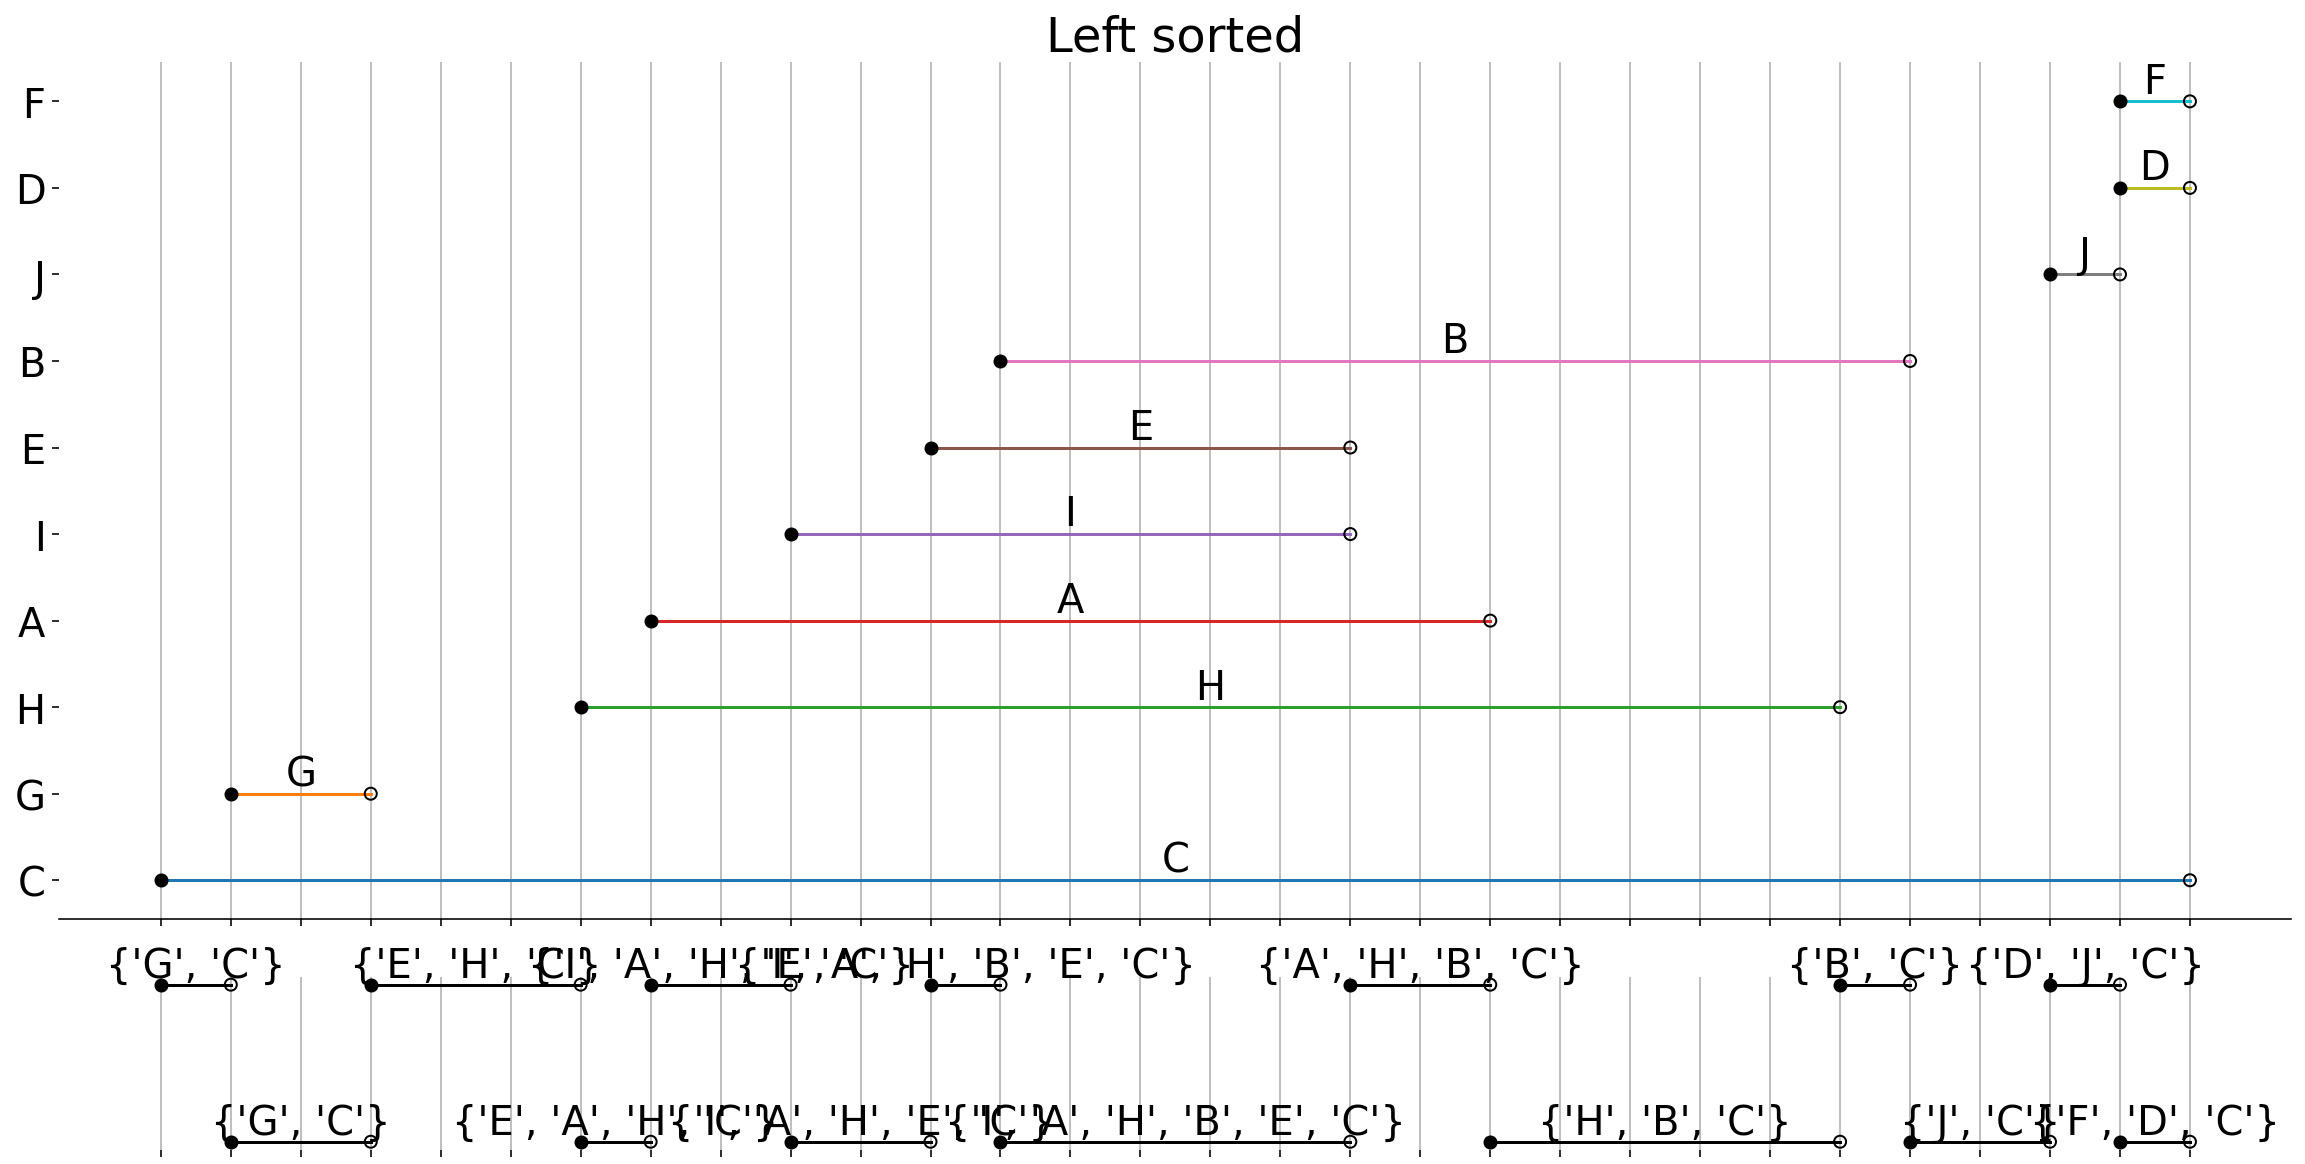

In [193]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1)

itvs = list(d.keys())
vals = list(d.values())

ax = plot_itvs(l, llengths, lvals, "Left sorted", ax)

divider = make_axes_locatable(ax)
axInt = divider.append_axes("bottom", 1.2, pad=0.4, sharex=ax)

plot_elem(itvs, [y-x for x, y in itvs], vals, axInt)


fig.show()

# Now intersect the elementary intervals

In [194]:
# i rolled my own but python provides set1.intersection(set2)
def intersect(v1, v2):
  ret = set()
  if len(v1) >= len(v2):
    for i in v2:
      if i in v1:
        ret.add(i)
  elif len(v1) < len(v2):
    for i in v1:
      if i in v2:
        ret.add(i)
  return ret

In [195]:
intersect({}, {1, 5, 6, 6})

set()

In [204]:
{1, 3, 4, 5}.intersection({1, 5, 6, 6})

{1, 5}

In [205]:
vals
prev = vals.pop()
for v in vals:
  prev = prev.intersection(v)

prev

{'C'}